In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
from statsmodels.compat import lzip
import statsmodels.api as sm

The "Duncan" data from statsmodels has 45 rows and 4 columns and contains data on the 'prestige' and other characteristics of some U.S. occupations in the year 1950:

In [2]:
duncan_prestige = sm.datasets.get_rdataset("Duncan", "carData")
Y = duncan_prestige.data['income']
X = duncan_prestige.data['education']
X = sm.add_constant(X)

In [3]:
duncan_prestige.data.head()

,type,income,education,prestige
accountant,prof,62,86,82
pilot,prof,72,76,83
architect,prof,75,92,90
author,prof,55,90,76
chemist,prof,64,86,90


In [4]:
class OLS():
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.reg = LinearRegression().fit(self.X, self.y)
        # self.reg = sm.OLS(self.y, self.X)
        self.summary = sm.OLS(self.y, self.X).fit().summary()
        predictions = self.reg.predict(self.X)
        # predictions = self.reg.fit()
        self.df_results = pd.DataFrame({'Actual': self.y, 'Predicted': predictions})
        self.df_results['Residuals'] = abs(self.df_results['Actual']) - abs(self.df_results['Predicted'])
        
    def predict(self, X):
        return self.reg.predict(X)
    
    def results(self):
        print('R^2: {0}'.format(self.reg.score(self.X, self.y)))
    
    def linear_assumption(self):
        df_results = self.df_results
        print("Assumption 1: Linear Relationship exists between the DV and the IV(s).", '\n')
        print("Checking with a scatter plot of actual vs. predicted.",
             'Preditions should follow the diagonal line.')
        
        sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False, height=7)
        
        line_coords = np.arange(df_results.min().min(), df_results.max().max())
        plt.plot(line_coords, line_coords,
                color='darkorange', linestyle='--')
        plt.title('Actual vs. Predicted')
        plt.show()
        
    def normal_errors_assumption(self):
        print("Assumption 2: The error terms are normally distributed.", '\n')
        
        print('Using the Anderson-Darling test for normal distribution:')
        
        p_value = normal_ad(self.df_results['Residuals'])[1]
        print('p-value from the test - below 0.05 generally means non-normal:', round(p_value, 2))
        
        if round(p_value, 2) < 0.05:
            print('Residuals are not normally distributed.')
        else:
            print('Residuals are normally distributed.')
            
        plt.subplots(figsize=(12, 6))
        plt.title('Distribution of Residuals')
        sns.histplot(self.df_results['Residuals'])
        plt.show()
        
        if p_value > 0.05:
            print('Assumption satisfied.')
        else:
            print('Assumption not satisfied.')
            print('Confidence intervals will likely be affected.')
            print('Try performing nonlinear transformations on variables.')
            
    def multicollinearity_assumption(self, feature_names=None):
        print("Assumption 3: Little to no multicollinearity among predictors.")
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(pd.DataFrame(self.X, columns=feature_names).corr(), annot=True)
        plt.title('Correlation of Variables')
        plt.show()
        
        print('Variance Inflation Factors (VIF):')
        print('>10: An indication that multicollinearity may be present.')
        print('>100: Certain multicollinearity among the variables.')
        print('------------------------------------')
        
        VIF = [variance_inflation_factor(self.X.values, i) for i in range(len(self.X.columns))]
        for idx, vif in enumerate(VIF):
            print('{0}: {1}'.format(idx, vif))
            
        possible_multicollinearity = sum([1 for vif in VIF if vif > 10])
        definite_multicollinearity = sum([1 for vif in VIF if vif > 100])
        
        print('{0} cases of possible multicollinearity.'.format(possible_multicollinearity))
        print('{0} cases of definite multicollinearity.'.format(definite_multicollinearity))
        
        if definite_multicollinearity == 0:
            if possible_multicollinearity == 0:
                print('Assumption satisfied.')
            else:
                print("Assumption possibly satisfied.")
                print('Coefficient interpretability may be problematic.')
                print('Consider removing variables with a high Variance Inflation Factor (VIF).')
                
        else:
            print('Assumption not satisfied.')
            print('Coefficient interpretability will be problematic.')
            print('Consider removing variables with a high Variance Inflation Factor (VIF).')
            
    def autocorrelation_assumption(self):
        print('Assumption 4: No Autocorrelation.', '\n')
        
        print('\nPerforming Durbin-Watson Test...')
        print('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data.')
        print('0 to 2 < is positive autocorrelation.')
        print('>2 to 4 is negative autocorrelation.')
        print('---------------------------------------')
        
        durbinWatson = durbin_watson(self.df_results['Residuals'])
        
        print('Durbin-Watson:', durbinWatson)
        
        if durbinWatson < 1.5:
            print('Signs of positive autocorrelation.', '\n')
            print('Assumption not satisfied.')
        elif durbinWatson > 2.5:
            print('Signs of negative autocorrelation.', '\n')
            print('Assumption not satisfied.')
        else:
            print('Little to no autocorrelation.', '\n')
            print('Assumption satisfied.')
            
    def homoskedasticity_assumption(self):
        print('Assumption 5: Homoskedasticity of Error Terms.', '\n')
        print('Residuals should have relative constant variance.')
        
        plt.subplots(figsize=(12, 6))
        ax = plt.subplot(111)
        plt.scatter(x=self.df_results.index, y=self.df_results.Residuals, alpha=0.5)
        plt.plot(np.repeat(0, int(len(self.df_results))), color='darkorange', linestyle='--')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.title('Residuals')
        plt.show()
        
        names = ['Lagrange multiplier statistic', 'p-value',
                'f-value', 'f p-value']
        
        test = het_breuschpagan(self.df_results['Residuals'], self.X)
        
        results = lzip(names, test)
        
        print(results, '\n')
        print(results[1][1])
        
        if results[1][1] >= 0.05:
            print("Because the p-value is not less than 0.05, we fail to reject the null hypothesis.\n")
            print(
                "We do not have sufficient evidence to say that heteroskedasticity is present in the regression model."
            )
            
        else:
            print("Because the p-value is less than 0.05, we reject the null hypothesis in favor of\n")
            print("the alternative hypothesis.\n")
            print("We have sufficient evidence to say that heteroskedasticity is present in the regression model.")
            print("\nWe should try transforming the DV by taking it's log instead or find a new definition of")
            print("the dependent variable. One way to do this would be to take the rate instead of the raw value.")
            
    def all_assumptions(self):
        self.linear_assumption()
        print('-' * 120)
        ols.normal_errors_assumption()
        print('-' * 120)
        ols.multicollinearity_assumption()
        print('-' * 120)
        ols.autocorrelation_assumption()
        print('-' * 120)
        ols.homoskedasticity_assumption()
        print('-' * 120)

In [5]:
ols = OLS(X, Y)

In [6]:
ols.predict(X)

array([61.76141016, 55.81281576, 65.3305668 , 64.14084792, 61.76141016,
       60.57169128, 65.92542624, 70.08944232, 62.3562696 , 61.76141016,
       54.62309688, 68.89972344, 68.304864  , 60.57169128, 64.73570736,
       30.82871928, 37.37217312, 43.91562696, 36.77731368, 59.3819724 ,
       53.433378  , 43.32076752, 52.83851856, 40.34647032, 24.28526544,
       33.80301648, 27.25956264, 29.6390004 , 23.690406  , 25.47498432,
       27.85442208, 14.7675144 , 26.06984376, 21.90582768, 19.52638992,
       22.50068712, 26.06984376, 27.25956264, 20.7161088 , 23.690406  ,
       28.44928152, 25.47498432, 22.50068712, 38.561892  , 29.6390004 ])

In [7]:
ols.results()

R^2: 0.5249181546907555


In [8]:
ols.reg.intercept_

10.603498317842252

In [9]:
ols.reg.coef_

array([0.        , 0.59485944])

In [10]:
ols.summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 income   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     47.51
Date:                Tue, 16 Mar 2021   Prob (F-statistic):           1.84e-08
Time:                        14:37:43   Log-Likelihood:                -190.42
No. Observations:                  45   AIC:                             384.8
Df Residuals:                      43   BIC:                             388.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.6035      5.198      2.040      0.048       0.120      21.087
education      0.5949      0.086      6.893      0.000       0.421       0.769
==============================================================================
Omnibus:                        9.841   Durbin-Watson:                   1.736
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               10.609
Skew:                           0.776   Prob(JB):                      0.00497
Kurtosis:                       4.802   Cond. No.                         123.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Assumption 1: Linear Relationship exists between the DV and the IV(s). 

Checking with a scatter plot of actual vs. predicted. Preditions should follow the diagonal line.


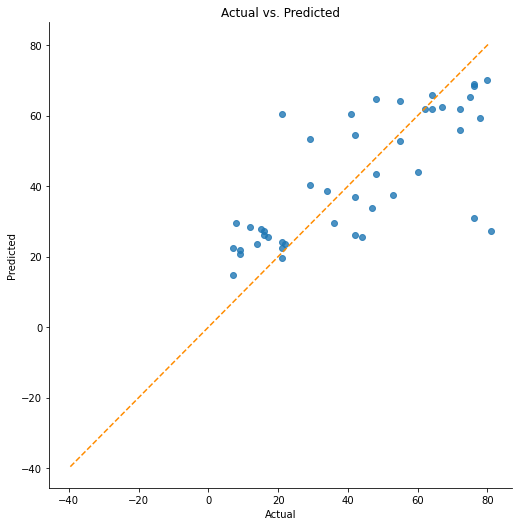

In [11]:
ols.linear_assumption()

Assumption 2: The error terms are normally distributed. 

Using the Anderson-Darling test for normal distribution:
p-value from the test - below 0.05 generally means non-normal: 0.1
Residuals are normally distributed.


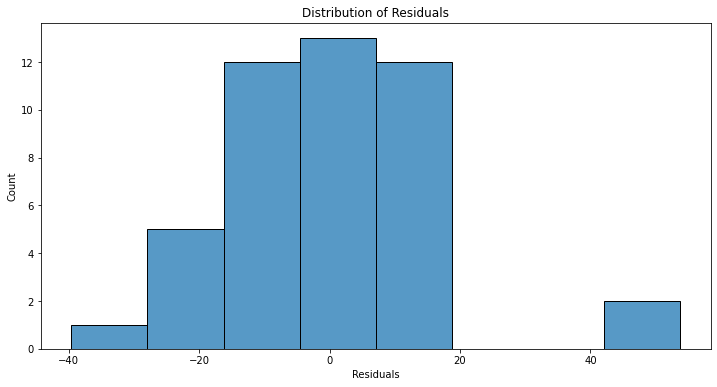

Assumption satisfied.


In [12]:
ols.normal_errors_assumption()

Assumption 3: Little to no multicollinearity among predictors.


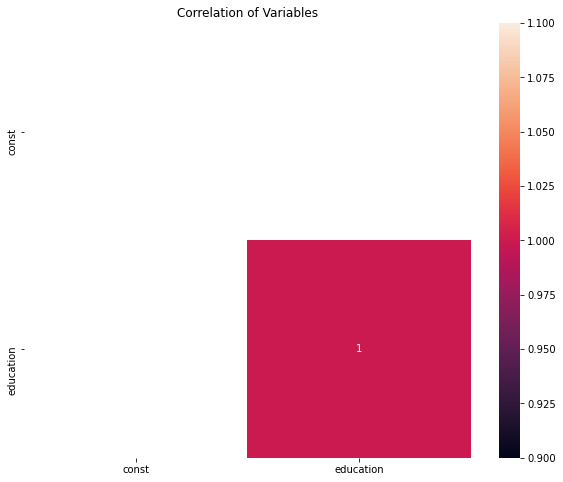

Variance Inflation Factors (VIF):
>10: An indication that multicollinearity may be present.
>100: Certain multicollinearity among the variables.
------------------------------------
0: 4.189385299652164
1: 1.0
0 cases of possible multicollinearity.
0 cases of definite multicollinearity.
Assumption satisfied.


In [13]:
ols.multicollinearity_assumption()

In [14]:
ols.autocorrelation_assumption()

Assumption 4: No Autocorrelation. 


Performing Durbin-Watson Test...
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data.
0 to 2 < is positive autocorrelation.
>2 to 4 is negative autocorrelation.
---------------------------------------
Durbin-Watson: 1.7360753650594405
Little to no autocorrelation. 

Assumption satisfied.


Assumption 5: Homoskedasticity of Error Terms. 

Residuals should have relative constant variance.


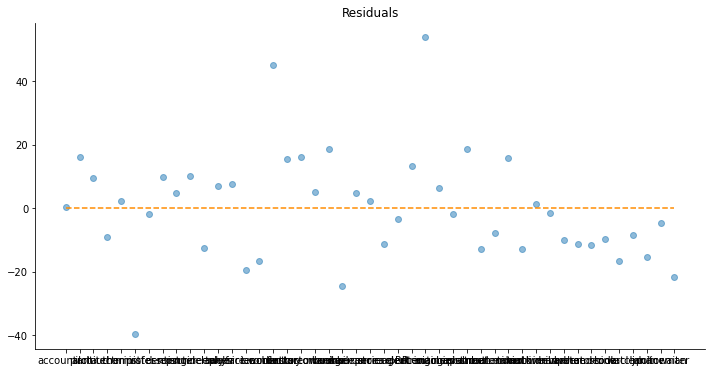

[('Lagrange multiplier statistic', 0.2864856558843232), ('p-value', 0.5924814566555369), ('f-value', 0.27550693305427887), ('f p-value', 0.6023572731912881)] 

0.5924814566555369
Because the p-value is not less than 0.05, we fail to reject the null hypothesis.

We do not have sufficient evidence to say that heteroskedasticity is present in the regression model.


In [15]:
ols.homoskedasticity_assumption()